# Normal ANN for observation operator

## Load in the required data

In [ ]:
import os
import pandas as pd
from pathlib import Path
pad = Path(os.getcwd())
if pad.name == "ml_observation_operator":
    pad_correct = pad.parent
    os.chdir(pad_correct)
%run "ml_observation_operator/data_load_in.py"

Load in and select

In [ ]:
ML_data_pad = Path("data/Zwalm_data/ML_data")
X_train_all = pd.read_pickle(ML_data_pad/"X_train.pkl")
X_test_all = pd.read_pickle(ML_data_pad/"X_test.pkl")
X_full_all = pd.read_pickle(ML_data_pad/"X_full.pkl")

X_train = pd.read_pickle(ML_data_pad/"X_train.pkl")
X_test = pd.read_pickle(ML_data_pad/"X_test.pkl")
X_full = pd.read_pickle(ML_data_pad/"X_full.pkl")

X_train_small = pd.read_pickle(ML_data_pad/"X_train_small.pkl")
X_test_small = pd.read_pickle(ML_data_pad/"X_test_small.pkl")
X_full_small = pd.read_pickle(ML_data_pad/"X_full_small.pkl")

y_train = pd.read_pickle(ML_data_pad/"y_train.pkl")
y_test = pd.read_pickle(ML_data_pad/"y_test.pkl")
y_full = pd.read_pickle(ML_data_pad/"y_full.pkl")

Cstar = pd.read_pickle(ML_data_pad/"Cstar.pkl")

Analogous to the simple linear regression, delta_t is dropped because this does not contain valuable info when not including multiple timesteps!

In [ ]:
X_train = X_train.drop('delta_t',axis = 1)
X_test = X_test.drop('delta_t',axis = 1)
X_full = X_full.drop('delta_t',axis = 1)
display(X_full.head())

X_train_small = X_train_small.drop('delta_t',axis = 1)
X_test_small = X_test_small.drop('delta_t',axis = 1)
X_full_small = X_full_small.drop('delta_t',axis = 1)
display(X_full_small.head())

## Load in used packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import (models,layers)
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from functions.plotting_functions import plot_tf_history
SEED =1234
#os.environ['PYTHONHASHSEED'] = str(SEED)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
python_random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
%load_ext autoreload 
%autoreload 2 

Normalisation of features

In [ ]:
n_features = X_full.shape[1]
print("Number of features: " + str(n_features))
scaler = StandardScaler()
scaler.fit(y_train.values.reshape(-1,1))
y_train_norm = scaler.transform(y_train.values.reshape(-1,1))
y_test_norm = scaler.transform(y_test.values.reshape(-1,1))

X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

X_scaler_small = StandardScaler()
X_scaler_small.fit(X_train_small)
X_train_small = X_scaler_small.transform(X_train_small)
X_test_small = X_scaler_small.transform(X_test_small)

# Recreate Linear Regression in tensorflow

https://stackoverflow.com/questions/75759597/typeerror-isinstance-arg-2-must-be-a-type-or-tuple-of-types-in-tensorflow-add why typeguard specification is needed

In [ ]:
lin_reg = models.Sequential(
    [
    layers.Input(shape = (n_features,)),
    #layers.Normalization(),
    layers.Dense(1, activation = "linear", name = 'layer1'), #first number = dimensionality of the output space!
    ]
)
lin_reg.summary()

lin_reg.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = 'adam',
    metrics = tfa.metrics.RSquare()
)

Once the optimal number of epochs per method has been determined, set `VAL_FRAC` to zero

In [ ]:
epochs = 200
VAL_FRAC = 0 
history = lin_reg.fit(
    X_train, y_train_norm, batch_size= 32, epochs = epochs, 
    validation_split = VAL_FRAC, verbose = 1#, callbacks = callbacks
)

In [ ]:
plot_tf_history(history, plot_object = 'r_square')

In [ ]:
y_train_hat = lin_reg.predict(X_train)
y_test_hat = lin_reg.predict(X_test)

In [ ]:
fig,ax = plt.subplots()
Cstar_SAR_time = Cstar[X_full_all.index]
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(X_train_all.index, scaler.inverse_transform(y_train_hat), label = 'Train', alpha = 0.7)
plt.plot(X_test_all.index, scaler.inverse_transform(y_test_hat), label = 'Test', alpha = 0.7)
ax.legend()
ax.set_title('Linear regression tensorflow')

In [ ]:
r2_train = r2_score(y_train, scaler.inverse_transform(y_train_hat))
r2_test = r2_score(y_test, scaler.inverse_transform(y_test_hat))
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))

Performance basically equal to when Linear Regression or Lasso trained on normalised features!

# Simple ANN model

https://github.com/keras-team/keras/issues/597 validation_split argument in `.fit()` does not shuffle the dataset! 

## Full dataset

Following the recommendataions as given in [understanding-deep-learning-chitta-ranjan-2021b](https://drive.google.com/file/d/1fejSMGPIDMO4eilsIDj-7QcFsCge4vdv/view)

use 2 hidden layers as default
- 1st layer: #nodes = 1/2 of of input nodes 
- 2nd layer: #nodes = 1/2 of number of nodes in previous layer

relu as default activation and no dropout

notes from 18/03/2023:
- to tanh activation layer: this allows -1 to 1 as output of activation function = seems better suited for prediction task at hand? above less important when using a linear output layer!

In [ ]:
ann = models.Sequential(
    [
    layers.Input(shape = (n_features,)),
    #layers.Normalization(), #replaced by normalisation with sklearn
    layers.Dense(8, activation = "relu", name = 'layer1'), #first number = dimensionality of the output space!
    layers.Dense(4, activation = "relu", name = 'layer2'),
    layers.Dense(1, activation = "linear", name = 'layer3'),
    ]
)

ann.summary()

In [ ]:
# batch_size  = 32
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# print(list(dataset.as_numpy_iterator())[0])
# dataset = dataset.shuffle(buffer_size=X_train.shape[0]).batch(batch_size)
# print(list(dataset.as_numpy_iterator())[0])

In [ ]:
ann.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = 'adam',
    metrics = tfa.metrics.RSquare()   
)

https://keras.io/guides/training_with_built_in_methods/

on Numpy array below

In [ ]:
epochs = 50
# callbacks = [
#     keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_loss",
#         # "no longer improving" being defined as "no better than  less"
#         min_delta= 1e-3,
#         # "no longer improving" being further defined as "for at least 2 epochs"
#         patience=20,
#         verbose=1,
#     )
# ]
history = ann.fit(
    X_train, y_train_norm, batch_size= 32, epochs = epochs, validation_split = VAL_FRAC#, callbacks = callbacks
)

In [ ]:
fig, ax = plot_tf_history(history, plot_object = 'r_square')


Flattens 

In [ ]:
y_train_hat = ann.predict(X_train)
y_test_hat = ann.predict(X_test)

In [ ]:
fig,ax = plt.subplots()
Cstar_SAR_time = Cstar[X_full_all.index]
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(X_train_all.index, scaler.inverse_transform(y_train_hat), label = 'Train', alpha = 0.7)
plt.plot(X_test_all.index, scaler.inverse_transform(y_test_hat), label = 'Test', alpha = 0.7)
# plt.plot(X_train.index, y_train_hat, label = 'Train', alpha = 0.7)
# plt.plot(X_test.index, y_test_hat, label = 'Test', alpha = 0.7)
ax.legend()
ax.set_title('ANN: limited nodes, full dataset')


In [ ]:
r2_train = r2_score(y_train, scaler.inverse_transform(y_train_hat))
r2_test = r2_score(y_test, scaler.inverse_transform(y_test_hat))
# r2_train = r2_score(y_train, y_train_hat)
# r2_test = r2_score(y_test, y_test_hat)
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))


Really analogous behaviour to the linear model!

 ## The limited dataset

Working with only 4 and 2 seems to limited. Therefore sticking to 8 and 4.

Alternative: 1 hidden layer, 1 

In [ ]:
n_features_small = X_train_small.shape[1]
print(n_features_small)
ann = models.Sequential(
    [
    layers.Input(shape = (n_features_small,)),
    #layers.Normalization(), #replaced by normalisation with sklearn
    layers.Dense(8, activation = "tanh", name = 'layer1'), #first number = dimensionality of the output space!
    layers.Dense(4, activation = "tanh", name = 'layer2'),
    layers.Dense(1, activation = "linear", name = 'layer3'),
    ]
)
ann.summary()
ann.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(),
    metrics = tfa.metrics.RSquare()
)

In [ ]:
epochs = 15
history = ann.fit(
    X_train_small, y_train_norm, batch_size= 32, epochs = epochs, validation_split = VAL_FRAC
)
fig, ax = plot_tf_history(history, plot_object = 'r_square')

In [ ]:
y_train_hat = ann.predict(X_train_small)
y_test_hat = ann.predict(X_test_small)
fig,ax = plt.subplots()
Cstar_SAR_time = Cstar[X_full_all.index]
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(X_train_all.index, scaler.inverse_transform(y_train_hat), label = 'Train', alpha = 0.7)
plt.plot(X_test_all.index, scaler.inverse_transform(y_test_hat), label = 'Test', alpha = 0.7)
ax.legend()
ax.set_title('ANN: limited nodes, limited dataset')
r2_train = r2_score(y_train, scaler.inverse_transform(y_train_hat))
r2_test = r2_score(y_test, scaler.inverse_transform(y_test_hat))
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))

Worse performance than the linear model

# More extended MLP model

## Full dataset

Recommendation of Hans: 2n+1 as number of nodes

In [ ]:
2*n_features+1

round off to 32 (a power of 2)

In [ ]:
ann_extended = models.Sequential(
    [
    layers.Input(shape = (n_features,)),
    layers.Dense(32, activation = "relu", name = 'layer1'), #first number = dimensionality of the output space!
    layers.Dropout(0.2),
    layers.Dense(16, activation = "relu", name = 'layer2'),
    layers.Dropout(0.2),    
    layers.Dense(1, activation = "linear", name = 'layer3'),
    ]
)
ann_extended.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(),
    metrics = tfa.metrics.RSquare()
)
ann_extended.summary()
keras.utils.plot_model(ann_extended, show_shapes=True)

In [ ]:
history = ann_extended.fit(
    X_train, y_train_norm, batch_size= 32, epochs = 100, validation_split = VAL_FRAC#, callbacks = callbacks
)
plot_tf_history(history, plot_object= 'r_square')

In [ ]:
y_train_hat = ann_extended.predict(X_train)
y_test_hat = ann_extended.predict(X_test)
fig,ax = plt.subplots()
Cstar_SAR_time = Cstar[X_full_all.index]
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(X_train_all.index, scaler.inverse_transform(y_train_hat), label = 'Train', alpha = 0.7)
plt.plot(X_test_all.index, scaler.inverse_transform(y_test_hat), label = 'Test', alpha = 0.7)
ax.legend()
ax.set_title('ANN: extended nodes, extended dataset')
r2_train = r2_score(y_train, scaler.inverse_transform(y_train_hat))
r2_test = r2_score(y_test, scaler.inverse_transform(y_test_hat))
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))

### The limited dataset

In [ ]:
n_features_small*2+1

In [ ]:
ann_extended = models.Sequential(
    [
    layers.Input(shape = (n_features_small,)),
    layers.Dense(16, activation = "relu", name = 'layer1'), #first number = dimensionality of the output space!
    layers.Dense(8, activation = "relu", name = 'layer2'),
    layers.Dense(1, activation = "linear", name = 'layer3'),
    ]
)
ann_extended.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(),
    metrics = tfa.metrics.RSquare()
)
ann_extended.summary()

In [ ]:
epochs = 20
history = ann_extended.fit(
    X_train_small, y_train_norm, batch_size= 32, epochs = epochs, validation_split = VAL_FRAC
)
fig, ax = plot_tf_history(history, plot_object='r_square')

In [ ]:
y_train_hat = ann_extended.predict(X_train_small)
y_test_hat = ann_extended.predict(X_test_small)
fig,ax = plt.subplots()
Cstar_SAR_time = Cstar[X_full_all.index]
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(X_train_all.index, scaler.inverse_transform(y_train_hat), label = 'Train', alpha = 0.7)
plt.plot(X_test_all.index, scaler.inverse_transform(y_test_hat), label = 'Test', alpha = 0.7)
ax.legend()
ax.set_title('ANN: extended nodes, limited dataset')
r2_train = r2_score(y_train, scaler.inverse_transform(y_train_hat))
r2_test = r2_score(y_test, scaler.inverse_transform(y_test_hat))
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))

# A more complex model structure

Hypothesis: the sin and cos wave allow for better prediction of the wave pattern. However putthing them trought the activation function destroy their shape. Therefore the idea to only add them at the end directly to the last linear output layer!

https://keras.io/guides/functional_api/ will be needed to construct this model

In [ ]:
print(n_features-2)

In [ ]:
no_time_input = layers.Input(
    shape = (n_features-2,) #-2 since substract time features
 )
time_input = layers.Input(
    shape = (2,)
)
layer1_no_time = layers.Dense(8, activation='relu',name='layer1')(no_time_input)
layer2_no_time = layers.Dense(4, activation='relu',name='layer2')(layer1_no_time)
combined = layers.concatenate([layer2_no_time, time_input])
C_star_out = layers.Dense(1,activation='linear',name='output_layer')(combined)
complex_model = models.Model(
    inputs = [no_time_input, time_input],
    outputs = C_star_out,
)
keras.utils.plot_model(complex_model, show_shapes = True, show_layer_activations=True)

In [ ]:
complex_model.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = 'adam',
    metrics = tfa.metrics.RSquare()   
)

In [ ]:
X_train[:,-2:].shape

In [ ]:
epochs = 40
history = complex_model.fit(
    [X_train[:,:-2],X_train[:,-2:]],
    y_train_norm, batch_size= 32, epochs = epochs, validation_split = 0.2#, callbacks = callbacks
)

In [ ]:
fig, ax = plot_tf_history(history, "r_square")
ax.set_ylim(0,1)

In [ ]:
y_train_hat = complex_model.predict([X_train[:,:-2],X_train[:,-2:]])
y_test_hat = complex_model.predict([X_test[:,:-2],X_test[:,-2:]])
fig,ax = plt.subplots()
Cstar_SAR_time = Cstar[X_full_all.index]
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(X_train_all.index, scaler.inverse_transform(y_train_hat), label = 'Train', alpha = 0.7)
plt.plot(X_test_all.index, scaler.inverse_transform(y_test_hat), label = 'Test', alpha = 0.7)
ax.legend()
ax.set_title('more complex ANN strucutre')
r2_train = r2_score(y_train, scaler.inverse_transform(y_train_hat))
r2_test = r2_score(y_test, scaler.inverse_transform(y_test_hat))
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))

## Hyperparameter tuning

https://www.tensorflow.org/tutorials/keras/keras_tuner



In [ ]:
import keras_tuner as kt

In [ ]:
# def model_builder(hp):
#     model = keras.Sequential()
#     model.add(layers.Input(shape = (n_features,)))
#     model.add(layers.Normalization())
#     hp_units = hp.Int('units', min_value = 5, max_value = 50, step = 5)
#     model.add(layers.Dense(units = hp_units, activation = 'relu'))
#     hp_units_2 = hp.Int('units', min_value = 5, max_value = 50, step = 5)
#     model.add(layers.Dense(units = hp_units_2, activation = 'relu'))
#     hp_units_3 = hp.Int('units', min_value = 5, max_value = 50, step = 5)
#     model.add(layers.Dense(units = hp_units_3, activation = 'relu'))
    
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss = keras.losses.MeanSquaredError())
    
#     return model    

https://keras.io/guides/keras_tuner/getting_started/

Keep default learning rate to limit number of parameter choices 

In [ ]:
def build_model(hp):
    """
    Builds model and sets up hyperparameter space to search.
    
    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    # Initialize sequential API and start building model.
    model = models.Sequential()
    model.add(layers.Input(shape = (n_features,)))
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 4
    # Number of Units: 5 - 50 with stepsize of 5 
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(
            layers.Dense(
                units=hp.Int("units_" + str(i), min_value=4, max_value=32, step=4),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.5 with stepsize of 0.1.
        model.add(layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.5, step=0.2)))
    
    # Add output layer.
    model.add(layers.Dense(units=1, activation='linear'))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    #hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(),#learning_rate=hp_learning_rate),
                  loss=keras.losses.MeanSquaredError(),
                  metrics = tfa.metrics.RSquare()
                  )
    
    return model

https://keras.io/api/keras_tuner/tuners/sklearn/ is also a possibility

Idea to use 20% validation data: based on this determine your optimal hyperparameters!

In [ ]:
tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     project_name = 'Gridsearch',
                     executions_per_trial = 1) #rounds of training per hyperparameter combo!
                     #max_epochs=100)
tuner.search_space_summary()

So default 20% is kept as validation!

In [ ]:
tuner.search(X_train, y_train_norm, epochs = 100, batch_size = 32,  validation_split = 0.2)

In [ ]:
best_hps=tuner.get_best_hyperparameters()
print('The best learning rate: ' + str(best_hps[0].get('learning_rate')))
print('Optimal number of layers: ' + str(best_hps[0].get('num_layers')))
print('Best number of units first layer 1: ' +  str(best_hps[0].get('units_1')))
print('Best number of units first layer 2: ' +  str(best_hps[0].get('units_2')))
print('Best number of units first layer 3: ' +  str(best_hps[0].get('units_3')))

In [ ]:
model_tuned = tuner.hypermodel.build(best_hps[0])
model_tuned.summary()

In [ ]:
history = model_tuned.fit(X_train, y_train_norm, epochs = 100, batch_size = 32,  validation_split = VAL_FRAC)

In [ ]:
plot_tf_history(history, 'r_square')

In [ ]:
y_train_tuned_hat = model_tuned.predict(X_train)
y_test_tuned_hat = model_tuned.predict(X_test)

In [ ]:
fig,ax = plt.subplots()
Cstar_SAR_time.plot(ax = ax, ylabel = 'C* [mm]', label = 'PDM')
plt.plot(X_train_all.index, scaler.inverse_transform(y_train_tuned_hat), label = 'Train', alpha = 0.7)
plt.plot(X_test_all.index, scaler.inverse_transform(y_test_tuned_hat), label = 'Test', alpha = 0.7)
# plt.plot(X_train.index, y_train_hat, label = 'Train', alpha = 0.7)
# plt.plot(X_test.index, y_test_hat, label = 'Test', alpha = 0.7)
r2_train = r2_score(y_train, scaler.inverse_transform(y_train_tuned_hat))
r2_test = r2_score(y_test, scaler.inverse_transform(y_test_tuned_hat))
print('R2 on training data: ' + str(r2_train))
print('R2 on test data: ' + str(r2_test))
ax.legend()
ax.set_title('ANN tuned')

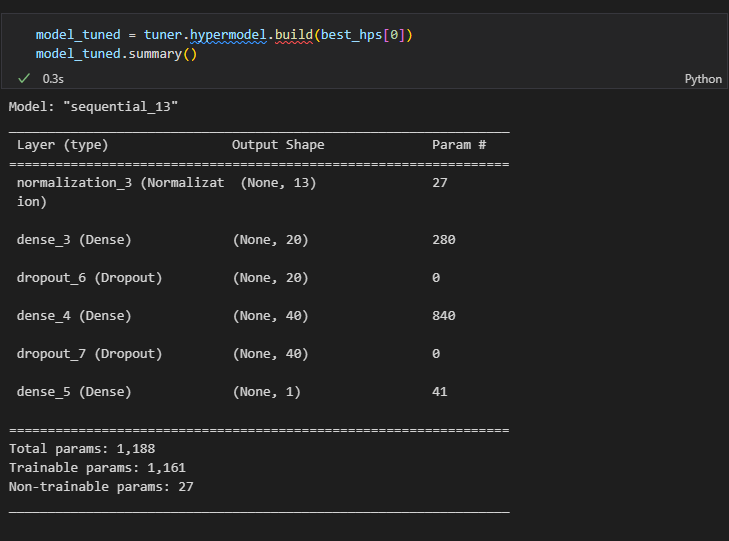

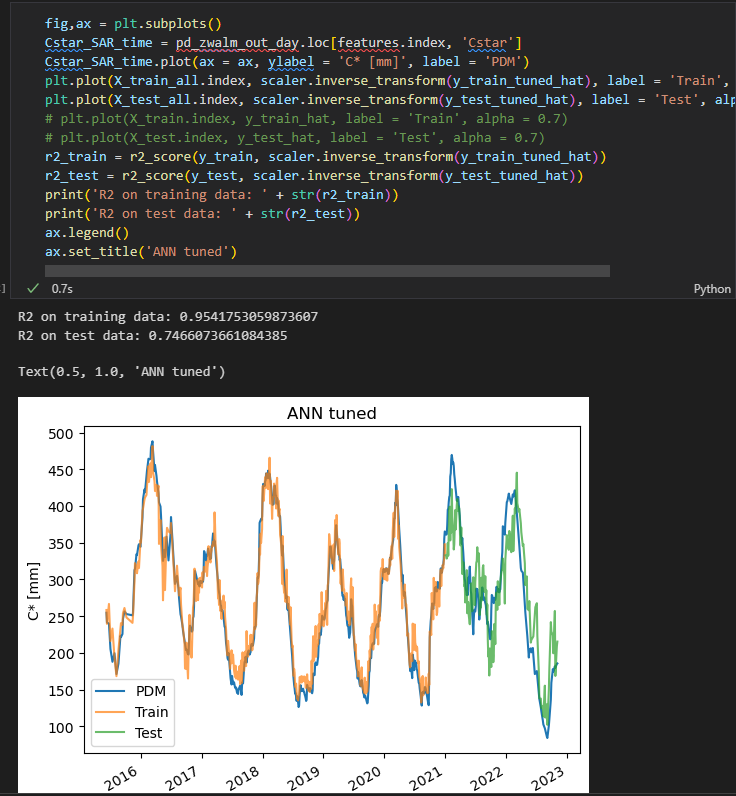